In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet scvi-tools[tutorials]==0.9.0

if IN_COLAB:
    !pip install --quiet scrublet
    !pip install --quiet --upgrade scikit-learn

In [2]:
!wget https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py

--2021-09-30 18:13:17--  https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11200 (11K) [text/plain]
Saving to: ‘alluvial.py.6’

alluvial.py.6       100%[===================>]  10.94K  --.-KB/s    in 0s      

2021-09-30 18:13:17 (37.2 MB/s) - ‘alluvial.py.6’ saved [11200/11200]



In [2]:
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

import alluvial
import anndata
import scvi
import scanpy as sc

# sc.set_figure_params(figsize=(4, 4))
if IN_COLAB:
    sc.settings.n_jobs=4
else:
    sc.settings.n_jobs=8
    
N_EPOCHS=250

scvi.settings.seed = 0

In [3]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [4]:
batch_colors = ["#FDB515", "#870052"]

## Gather data

In [5]:
import gdown
import time
time.sleep(5)
if IN_COLAB:
    !mkdir data
#     gdown.download(url="https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC", output="data/pbmc_seurat_v4.h5ad", quiet=False)
#     gdown.download(url="https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9", output="data/covid_cite.h5ad", quiet=False)
    !wget https://ndownloader.figshare.com/files/27458840 -O data/pbmc_seurat_v4.h5ad
    !wget https://ndownloader.figshare.com/files/27458837 -O data/covid_cite.h5ad

In [6]:
ref = anndata.read("data/pbmc_seurat_v4.h5ad")
query = anndata.read("data/covid_cite.h5ad")

### Scrub query doublets

In [7]:
import scrublet as scr

query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 40.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 31.5 seconds


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 6.2%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.0%
Elapsed time: 32.3 seconds


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
query = query[~query.obs.predicted_doublets].copy()
query

AnnData object with n_obs × n_vars = 54796 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'doublet_scores', 'predicted_doublets'
    obsm: 'pro_exp'

### Organize

In [9]:
protein_df = pd.DataFrame(index=ref.obsm["protein_counts"].index)
ref_proteins = ref.obsm["protein_counts"].columns
for p in ref_proteins:
    if p.split("-")[-1] == "1" or p.split("-")[-1] == "2":
        root = p.split("-")[0]
        if root not in ["Notch", "TCR"]:
            try:
                protein_df[root] = (
                    ref.obsm["protein_counts"][root + "-1"]
                    + ref.obsm["protein_counts"][root + "-2"]
                ).values
                print(root)
            except:
                protein_df[p] = ref.obsm["protein_counts"][p]
        else:
            protein_df[p] = ref.obsm["protein_counts"][p]
    else:
        protein_df[p] = ref.obsm["protein_counts"][p]
ref.obsm["protein_counts"] = protein_df

CD4
CD4
CD3
CD56
CD56
CD11b
CD11b
CD38
CD38
CD44
CD44
CD26
CD26
CD275
CD275
CD45
CD45
CD133
CD133
CD3
CD138
CD138


In [10]:
print(ref)
print(query)
query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
print(query.obsm["protein_counts"].shape)
# del query.obsm["pro_exp"]

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index'
    obsm: 'protein_counts'
AnnData object with n_obs × n_vars = 54796 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'doublet_scores', 'predicted_doublets'
    obsm: 'pro_exp'
(54796, 39)


In [11]:
ref.var['mt'] = ref.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ref, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

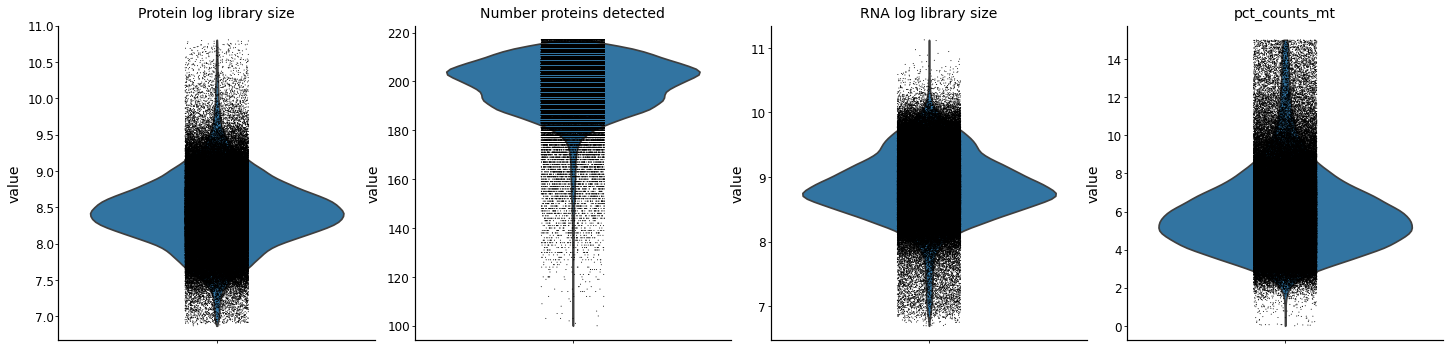

In [12]:
ref.obs["Protein log library size"] = np.log(ref.obsm["protein_counts"].sum(1))
ref.obs["Number proteins detected"] = (ref.obsm["protein_counts"] > 0).sum(1)
ref.obs["RNA log library size"] = np.log(ref.X.sum(1).A)
sc.pl.violin(ref, ["Protein log library size", "Number proteins detected", "RNA log library size", "pct_counts_mt"], multi_panel=True)


In [13]:
ref = ref[ref.obs["Protein log library size"] > 7.6]
ref = ref[ref.obs["Protein log library size"] < 10.3]
ref = ref[ref.obs["Number proteins detected"] > 150]
# filter doublet
ref = ref[ref.obs["celltype.l2"] != "Doublet"]
# MT
ref = ref[ref.obs["pct_counts_mt"] < 12].copy()

In [14]:
# remove isotypes
keep_pros = [not "IgG" in p for p in ref.obsm["protein_counts"].columns]
ref.obsm["protein_counts"] = ref.obsm["protein_counts"].iloc[:, keep_pros].copy()

keep_pros = [not ("Isotype" in p or "Anti" in p) for p in query.obsm["protein_counts"].columns]
query.obsm["protein_counts"] = query.obsm["protein_counts"].iloc[:, keep_pros].copy()

In [15]:
keep_pros = [not ("Isotype" in p or "Anti" in p) for p in query.obsm["protein_counts"].columns]
query.obsm["protein_counts"] = query.obsm["protein_counts"].iloc[:, keep_pros].copy()

#### Write query and ref so they can be converted to Seurat

In [16]:
ref_write = ref.copy()
del ref_write.obsm["protein_counts"]
ref_write.var = pd.DataFrame(index=ref_write.var_names)
ref_write.write_h5ad("data/scarches_totalvi_ref.h5ad")
ref_pro = sc.AnnData(ref.obsm["protein_counts"].copy(), obs=ref_write.obs)
ref_pro.write_h5ad("data/scarches_totalvi_ref_pro.h5ad")

query_write = query.copy()
del query_write.obsm["protein_counts"]
del query_write.obsm["pro_exp"]
query_write.write_h5ad("data/scarches_totalvi_query.h5ad")

del ref_write
del query_write

In [17]:
sc.pp.highly_variable_genes(
    ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
)

In [18]:
# randomly pick some proteins to be missing
rand_cats = np.random.permutation(ref.obs["orig.ident"].astype("category").cat.categories)[:5]
for r in rand_cats:
    ref.obsm["protein_counts"][ref.obs["orig.ident"] == r] = 0.0
#     rand_proteins = np.random.permutation(ref.obsm["protein_counts"].columns)[:50]
#     ref.obsm["protein_counts"].loc[ref.obs["orig.ident"] == r, rand_proteins] = 0.0

In [19]:
scvi.data.setup_anndata(
    ref,
    batch_key="orig.ident",
    protein_expression_obsm_key="protein_counts",
)

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_counts']                          
INFO     Using protein names from columns of adata.obsm['protein_counts']                    
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 152094 cells, 4000 vars, 24       
         batches, 1 labels, and 213 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

In [20]:
ref.obsm["protein_counts"].shape

(152094, 213)

In [21]:
# 4 isotyes in the 39
query.obsm["pro_exp"].shape

(54796, 39)

In [22]:
query = query[:, ref.var_names].copy()
query.obs["celltype.l3"] = "Unknown"
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]

# reorganize query proteins, missing proteins become all 0
for p in ref.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[:, ref.obsm["protein_counts"].columns]

In [23]:
ref.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

## TotalVI + scArches

In [24]:
def classify_from_latent(
    ref: sc.AnnData, 
    query: sc.AnnData, 
    ref_obsm_key: str = "X_totalvi_scarches", 
    labels_obs_key: str = "celltype.l2",
    classifier: str = "random_forest",
):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier

    y_train = ref.obs[labels_obs_key].astype("category").cat.codes.to_numpy()
    X_train = ref.obsm[ref_obsm_key]
    if classifier == "random_forest":
        clf = RandomForestClassifier(
            random_state=1, 
            class_weight = "balanced_subsample",
            verbose=1,
            n_jobs=-1,
        )
    else:
        clf = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32,), 
            random_state=1, 
            max_iter=300, 
            verbose=True, 
            early_stopping=True, 
            learning_rate_init=1e-3
        )
    clf.fit(X_train, y_train)
    predictions = clf.predict(query.obsm[ref_obsm_key])
    categories = ref.obs[labels_obs_key].astype("category").cat.categories
    cat_preds = [categories[i] for i in predictions]
    
    return cat_preds

In [25]:
def run_totalvi_scarches(ref, query):
    """Run online totalVI."""

    # initialize and train model
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        n_layers_decoder=2,
        n_layers_encoder=2,
    )

    start = time.time()
    vae = scvi.model.TOTALVI(
        ref, 
        **arches_params
    )
    vae.train(max_epochs=N_EPOCHS, batch_size=256, lr=4e-3)
    end = time.time()
    print("\n Total reference train time: {}".format(end-start))

    plt.plot(vae.history["elbo_validation"][10:], label="validation")
    plt.title("Negative ELBO over training epochs")
    plt.legend()

    ref.obsm["X_totalvi_scarches"] = vae.get_latent_representation()

    start = time.time()
    vae_q = scvi.model.TOTALVI.load_query_data(
        query, 
        vae,
    )

    vae_q.train(
        150, 
        lr=4e-3, 
        batch_size=256, 
        plan_kwargs=dict(
            weight_decay=0.0,
            scale_adversarial_loss=0.0
        ),
        # n_steps_kl_warmup=1,
    )
    end = time.time()
    print("\n Total query train time: {}".format(end-start))

    query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

    # predict cell types of query
    query.obs["predicted_l2_scarches"] = classify_from_latent(ref, query, ref_obsm_key="X_totalvi_scarches")
    query.obs["celltype.l2"] = query.obs["predicted_l2_scarches"]

    adata_full_new = anndata.concat([ref, query])
    adata_full_new.uns["_scvi"] = query.uns["_scvi"].copy()
    adata_full_new.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(adata_full_new)

    print("Computing full umap")
    sc.pp.neighbors(adata_full_new, use_rep="X_totalvi_scarches", metric="cosine")
    sc.tl.umap(adata_full_new, min_dist=0.3)

    return vae, vae_q, adata_full_new

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 250/250: 100%|██████████| 250/250 [55:48<00:00, 13.39s/it, loss=625, v_num=1]

 Total reference train time: 3356.280485391617
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 54796 cells, 4000 vars, 26        
         batches, 1 labels, and 213 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 150/150: 100%|██████████| 150/150 [10:18<00:00,  4.12s/it, loss=473, v_num=1] 

 Total query train time: 619.0782685279846


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Computing full umap


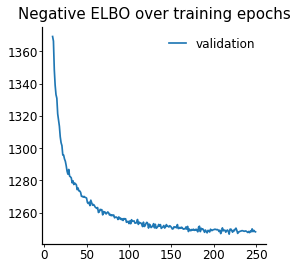

In [26]:
vae_arches, vae_q_arches, full_data_arches = run_totalvi_scarches(ref, query)

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'orig.ident' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'dataset_name' as categorical


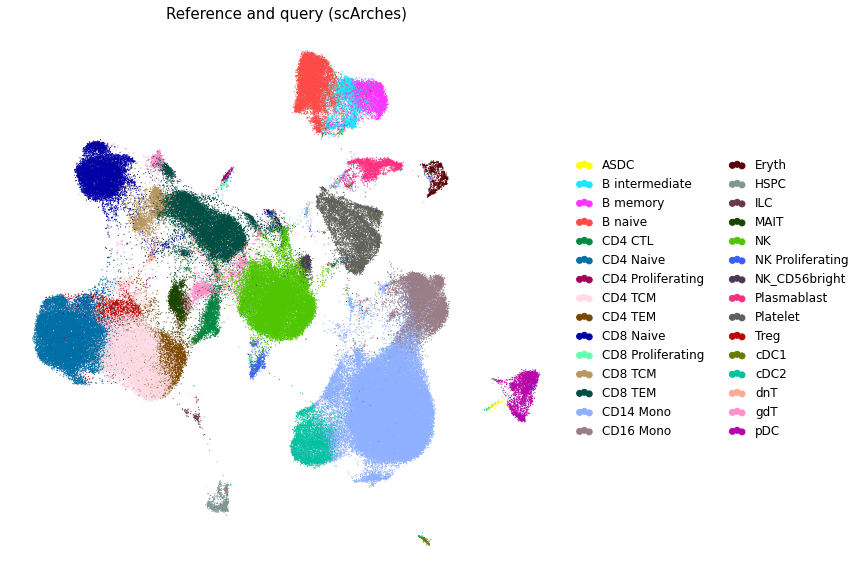

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(
    full_data_arches,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    ax=ax,
    size=5,
)

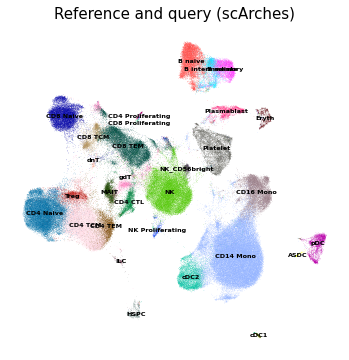

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_arches,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    legend_loc="on data",
    legend_fontsize="xx-small",
#     legend_fontoutline=1,
    ax=ax,
#     size=5,
)
fig.savefig("figs/scarches_ref_query_by_cell_type.pdf", bbox_inches="tight", dpi=DPI)

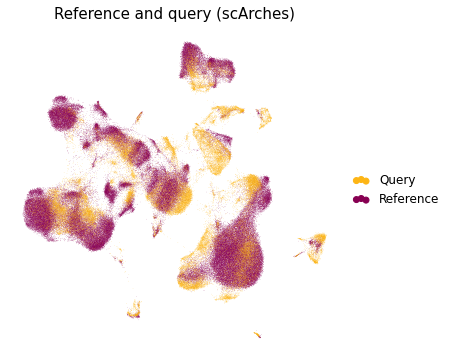

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_arches,
    color=["dataset_name"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    palette=batch_colors,
    ax=ax,
#     size=5,
)
fig.savefig("figs/scarches_ref_query.pdf", bbox_inches="tight", dpi=DPI)

## TotalVI default

In [30]:
def run_totalvi_default(ref, query):
    """Run 'offline' totalVI."""

    adata_full_new = anndata.concat([ref, query])
    scvi.data.setup_anndata(
        adata_full_new,
        batch_key="orig.ident",
        protein_expression_obsm_key="protein_counts",
    )

    # initialize and train model
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        n_layers_decoder=2,
        n_layers_encoder=2,
    )

    start = time.time()
    vae = scvi.model.TOTALVI(
        adata_full_new, 
        **arches_params
    )
    vae.train(max_epochs=N_EPOCHS, batch_size=256, lr=4e-3)
    end = time.time()
    print("\n Total default train time: {}".format(end-start))

    adata_full_new.obsm["X_totalvi_default"] = vae.get_latent_representation()


    plt.plot(vae.history["elbo_validation"][10:], label="validation")
    plt.title("Negative ELBO over training epochs")
    plt.legend()

    ref.obsm["X_totalvi_default"] = vae.get_latent_representation(ref)
    query.obsm["X_totalvi_default"] = vae.get_latent_representation(query)

    # predict cell types of query
    query.obs["predicted_l2_default"] = classify_from_latent(ref, query, ref_obsm_key="X_totalvi_default")


    query.obs["celltype.l2"] = query.obs["predicted_l2_default"]

    print("Computing full umap")
    sc.pp.neighbors(adata_full_new, use_rep="X_totalvi_default", metric="cosine")
    sc.tl.umap(adata_full_new, min_dist=0.3)

    return vae, adata_full_new

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_counts']                          
INFO     Using protein names from columns of adata.obsm['protein_counts']                    
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 206890 cells, 4000 vars, 26       
         batches, 1 labels, and 213 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 250/250: 100%|██████████| 250/250 [1:16:37<00:00, 18.39s/it, loss=553, v_num=1]

 Total default train time: 4603.691468954086
WARNING  Categorical encoding for batch is similar but not equal between the anndata used to 
         train and the anndata passed in. Will attempt transfer. Expected categories: ['P1_0'
         'P1_3' 'P1_7' 'P2_0' 'P2_3' 'P2_7' 'P3_0' 'P3_3' 'P3_7' 'P4_0'                      
          'P4_3' 'P4_7' 'P5_0' 'P5_3' 'P5_7' 'P6_0' 'P6_3' 'P6_7' 'P7_0' 'P7_3'              
          'P7_7' 'P8_0' 'P8_3' 'P8_7' 'set1' 'set2']. Received categories: ['P1_0' 'P1_3'    
         'P1_7' 'P2_0' 'P2_3' 'P2_7' 'P3_0' 'P3_3' 'P3_7' 'P4_0'                             
          'P4_3' 'P4_7' 'P5_0' 'P5_3' 'P5_7' 'P6_0' 'P6_3' 'P6_7' 'P7_0' 'P7_3'              
          'P7_7' 'P8_0' 'P8_3' 'P8_7'].                                                      
                                                                                             
INFO     Found batches

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` para

Computing full umap


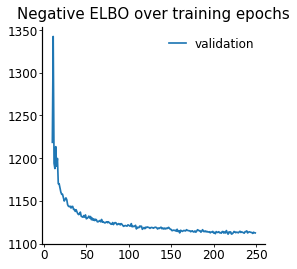

In [31]:
vae_default, full_data_default = run_totalvi_default(ref, query)

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'orig.ident' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'dataset_name' as categorical


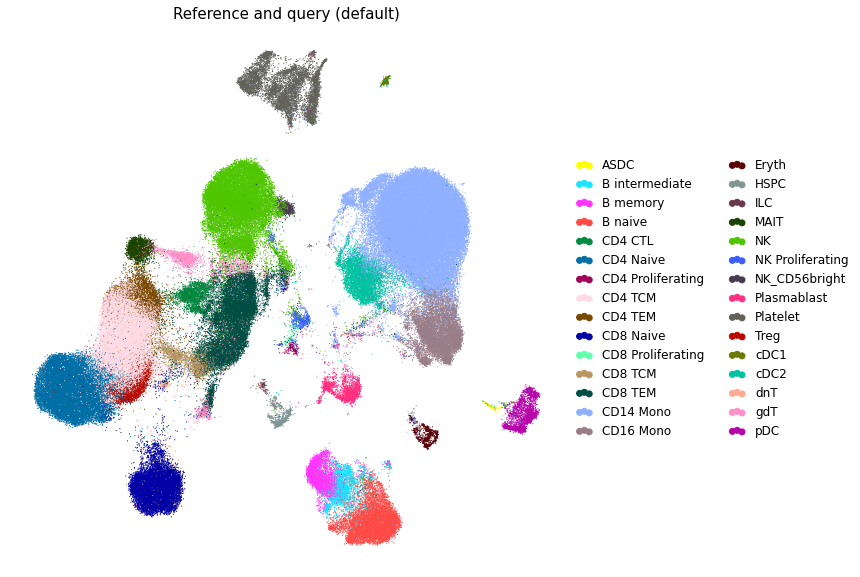

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(
    full_data_default,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (default)",
    ax=ax,
    size=5,
)

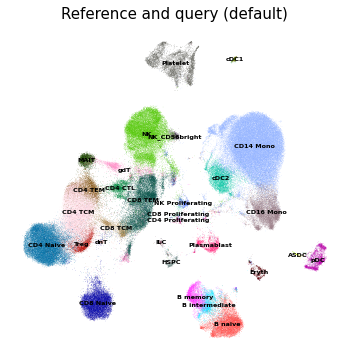

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_default,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (default)",
    legend_loc="on data",
    legend_fontsize="xx-small",
#     legend_fontoutline=1,
    ax=ax,
)
fig.savefig("figs/default_ref_query_by_cell_type.pdf", bbox_inches="tight", dpi=DPI)

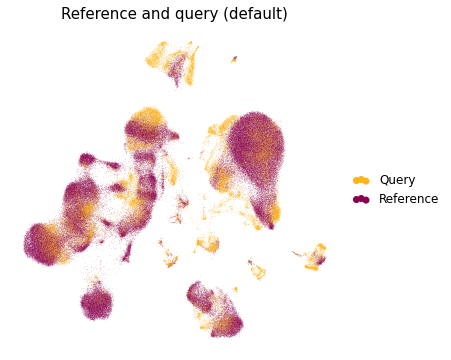

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_default,
    color=["dataset_name"],
    frameon=False,
    ncols=1,
    palette=batch_colors,
    title="Reference and query (default)",
    ax=ax,
#     size=5,
)
fig.savefig("figs/default_ref_query.pdf", bbox_inches="tight", dpi=DPI)

In [35]:
query.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust',
       'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1',
       'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og',
       'final_clust_withnum', 'final_clust_review', 'Age', 'Gender',
       'Gender_num', 'doublet_scores', 'predicted_doublets', 'celltype.l3',
       'celltype.l2', 'dataset_name', '_scvi_batch', '_scvi_labels',
       '_scvi_local_l_mean', '_scvi_local_l_var', 'predicted_l2_scarches',
       'predicted_l2_default'],
      dtype='object')

## Query specific analysis

In [36]:
sc.pp.neighbors(query, use_rep="X_totalvi_scarches")
sc.tl.umap(query)

In [37]:
# vae_q
df = vae_default.get_protein_foreground_probability(query, n_samples=10)

for c in df.columns:
    query.obs[c + "_prob_fg"] = df[c]

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
print(np.sort(df.columns.tolist()))

['B7-H4' 'C5L2' 'CCR10' 'CD102' 'CD103' 'CD105' 'CD106' 'CD107a' 'CD109'
 'CD110' 'CD112' 'CD115' 'CD117' 'CD119' 'CD11a/CD18' 'CD11b' 'CD11c'
 'CD122' 'CD123' 'CD124' 'CD126' 'CD127' 'CD13' 'CD133' 'CD134' 'CD135'
 'CD137' 'CD138' 'CD14' 'CD140a' 'CD140b' 'CD141' 'CD142' 'CD144' 'CD146'
 'CD15' 'CD152' 'CD154' 'CD155' 'CD158' 'CD158b' 'CD158e1' 'CD158f' 'CD16'
 'CD161' 'CD163' 'CD164' 'CD169' 'CD171' 'CD172a' 'CD177' 'CD178' 'CD18'
 'CD184' 'CD185' 'CD186' 'CD19' 'CD192' 'CD193' 'CD194' 'CD195' 'CD196'
 'CD199' 'CD1a' 'CD1c' 'CD1d' 'CD2' 'CD20' 'CD200' 'CD201' 'CD202b'
 'CD203c' 'CD204' 'CD205' 'CD206' 'CD207' 'CD209' 'CD21' 'CD22' 'CD223'
 'CD226' 'CD235a' 'CD235ab' 'CD24' 'CD243' 'CD244' 'CD25' 'CD252' 'CD253'
 'CD26' 'CD267' 'CD268' 'CD269' 'CD27' 'CD270' 'CD271' 'CD272' 'CD273'
 'CD274' 'CD275' 'CD278' 'CD279' 'CD28' 'CD284' 'CD29' 'CD294' 'CD3'
 'CD30' 'CD301' 'CD303' 'CD304' 'CD305' 'CD307c/FcRL3' 'CD307d' 'CD307e'
 'CD309' 'CD31' 'CD314' 'CD319' 'CD324' 'CD325' 'CD335' 'CD337' 

In [39]:
query.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth',
       ...
       'CD119_prob_fg', 'CD169_prob_fg', 'CD28_prob_fg', 'CD161_prob_fg',
       'CD163_prob_fg', 'CD138_prob_fg', 'CD164_prob_fg', 'CD144_prob_fg',
       'CD202b_prob_fg', 'CD11c_prob_fg'],
      dtype='object', length=254)

In [40]:
query_pro_df = query.obsm["pro_exp"]
query_pro_df.columns

Index(['CD3', 'CD4', 'CD8', 'CD19', 'CD20', 'CD56', 'CD69', 'CD28', 'CD95',
       'CD279-PD', 'CD197', 'CD45RO', 'CD45RA', 'HLA', 'CD14', 'CD16', 'CD11c',
       'CD1c-BDCA1', 'CD370-CLEC9A', 'CD123', 'CD86', 'CD274-PD', 'CD163',
       'CD33', 'CD57', 'CD27', 'CD38', 'CD25', 'CD34', 'TCRgd', 'TCRa7',
       'Anti', 'CD127', 'CD94', 'FCER1a', 'Isotype1', 'Isotype2', 'Isotype3',
       'Isotype4'],
      dtype='object')

(array([4.1370e+03, 1.4599e+04, 1.7514e+04, 1.2602e+04, 4.1400e+03,
        1.2510e+03, 2.7600e+02, 1.0000e+02, 6.6000e+01, 5.2000e+01,
        2.3000e+01, 1.4000e+01, 6.0000e+00, 7.0000e+00, 2.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.62612474,  1.2522495 ,  1.8783743 ,  2.504499  ,
         3.1306238 ,  3.7567487 ,  4.3828735 ,  5.008998  ,  5.635123  ,
         6.2612476 ,  6.8873725 ,  7.5134974 ,  8.139622  ,  8.765747  ,
         9.391871  , 10.017996  , 10.644121  , 11.270246  , 11.896371  ,
        12.522495  ], dtype=float32),
 <BarContainer object of 20 artists>)

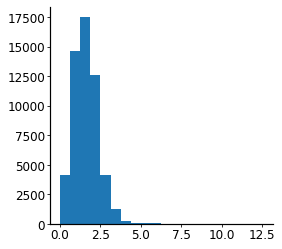

In [41]:
plt.hist(np.log1p(query_pro_df["CD19"]), bins=20)

... storing 'celltype.l3' as categorical
... storing 'celltype.l2' as categorical
... storing 'dataset_name' as categorical
... storing 'predicted_l2_scarches' as categorical
... storing 'predicted_l2_default' as categorical


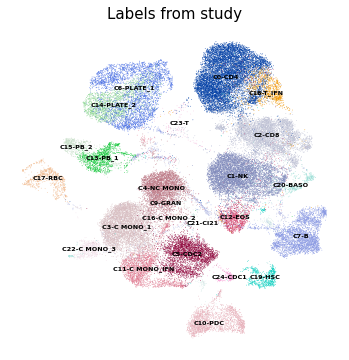

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["final_clust_review"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
#     legend_fontoutline=1,
    title="Labels from study",
    ax=ax,
)
fig.savefig("figs/query_truth_umap.pdf", bbox_inches="tight", dpi=DPI)

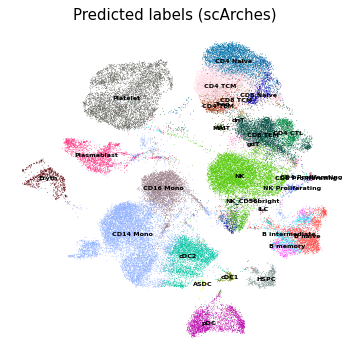

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["predicted_l2_scarches"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
#     legend_fontoutline=1,
    title="Predicted labels (scArches)",
    ax=ax,
)
fig.savefig("figs/query_arches_umap.pdf", bbox_inches="tight", dpi=DPI)

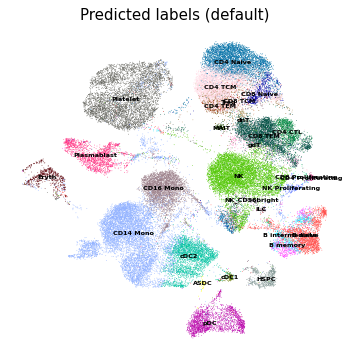

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["predicted_l2_default"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
#     legend_fontoutline=1,
    title="Predicted labels (default)",
    ax=ax,
)
fig.savefig("figs/query_default_umap.pdf", bbox_inches="tight", dpi=DPI)

## Plotting

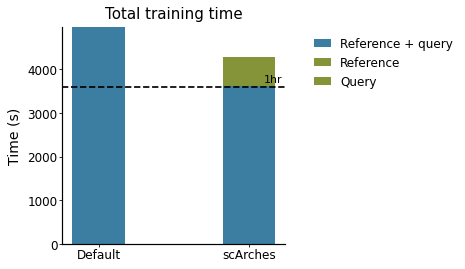

In [45]:
N = 2
default_times = [4982, 3624]
arches_times = [0, 666]

ind = np.arange(N)  # the x locations for the groups
width = 0.35  # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, default_times, width, color="#3B7EA1")
p2 = plt.bar(ind, arches_times, width, bottom=default_times, color="#859438")
# p2[0].set_color("blue")
# # p2[1].set_color("red")

plt.ylabel("Time (s)")
plt.title("Total training time")
plt.xticks(ind, ("Default", "scArches"))
plt.legend(
    (p1[0], p2[0], p2[1]),
    ("Reference + query", "Reference", "Query"),
    loc="upper right",
    bbox_to_anchor=(1.3, 0.5, 0.5, 0.5),
)
plt.axhline(3600, c="black", linestyle="--")
plt.text(1.1, 3700, "1hr")

plt.savefig("figs/time.pdf", bbox_inches="tight")

In [46]:
from matplotlib.colors import ListedColormap

colors = full_data_default.uns["celltype.l2_colors"]
ctype_cmap = ListedColormap(colors)

# color order using value counts
color_order = np.argsort(
    query.obs["predicted_l2_scarches"]
    .value_counts()
    .loc[full_data_default.obs["celltype.l2"].cat.categories]
)

In [112]:
a_order_main = [
    "B intermediate",
    "B naive",
    "B memory",
    "CD14 Mono",
    "CD16 Mono",
    "cDC1",
    "cDC2",
    "pDC",
    "CD4 Naive",
    "CD4 TCM",
    "CD4 TEM",
    "CD4 Proliferating",
    "Treg",
    "CD4 CTL",
    "CD8 Naive",
    "CD8 TCM",
    "CD8 TEM",
    "CD8 Proliferating",
    "dnT",
    "MAIT",
    "gdT",
    "NK",
    "NK Proliferating",
    "NK_CD56bright",
    "Platelet",
    "Plasmablast",
    "HSPC",
    "ILC",
    "ASDC",
    "Eryth",
]
b_order_main = [
    "C7-B",
    "C3-C MONO_1",
    "C16-C MONO_2",
    "C22-C MONO_3",
    "C11-C MONO_IFN",
    "C9-GRAN",
    "C4-NC MONO",
    "C24-CDC1",
    "C5-CDC2",
    "C10-PDC",
    "C0-CD4",
    "C18-T_IFN",
    "C2-CD8",
    "C23-T",
    "C20-BASO",
    "C1-NK",
    "C6-PLATE_1",
    "C14-PLATE_2",
    "C13-PB_1",
    "C15-PB_2",
    "C19-HSC",
    "C21-Cl21",
    "C17-RBC",
    "C12-EOS",
]
# manual color order
cats = full_data_default.obs["celltype.l2"].cat.categories
color_order = pd.Series(np.arange(len(cats)), index=cats)
color_order = color_order.loc[a_order_main].values[::-1]


ref_to_int = {
    "B intermediate": 0,
    "B naive": 0,
    "B memory": 0,
    "CD14 Mono": 1,
    "CD16 Mono": 12,
    "cDC1": 2,
    "cDC2": 3,
    "pDC": 4,
    "CD4 Naive": 5,
    "CD4 TCM": 5,
    "CD4 TEM": 5,
    "CD4 Proliferating": 5,
    "Treg": 5,
    "CD4 CTL": np.nan,
    "CD8 Naive": 6,
    "CD8 TCM": 6,
    "CD8 TEM": 6,
    "CD8 Proliferating": 6,
    "dnT": np.nan,
    "MAIT": np.nan,
    "gdT": np.nan,
    "NK": 7,
    "NK Proliferating": 7,
    "NK_CD56bright": 7,
    "Platelet": 8,
    "Plasmablast": 9,
    "HSPC": 10,
    "ILC": np.nan,
    "ASDC": np.nan,
    "Eryth": 11,
}
query_to_int = {
    "C7-B": 0,
    "C3-C MONO_1": 1,
    "C16-C MONO_2": 1,
    "C22-C MONO_3": 1,
    "C11-C MONO_IFN": 1,
    "C9-GRAN": np.nan,
    "C4-NC MONO": 12,
    "C24-CDC1": 2,
    "C5-CDC2": 3,
    "C10-PDC": 4,
    "C0-CD4": 5,
    "C18-T_IFN": np.nan,
    "C2-CD8": 6,
    "C23-T": np.nan,
    "C20-BASO": np.nan,
    "C1-NK": 7,
    "C6-PLATE_1": 8,
    "C14-PLATE_2": 8,
    "C13-PB_1": 9,
    "C15-PB_2": 9,
    "C19-HSC": 10,
    "C21-Cl21": np.nan,
    "C17-RBC": 11,
    "C12-EOS": np.nan
}

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/adam/Documents/scvi-tools-reproducibility/docs/alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(alluvial_fan)


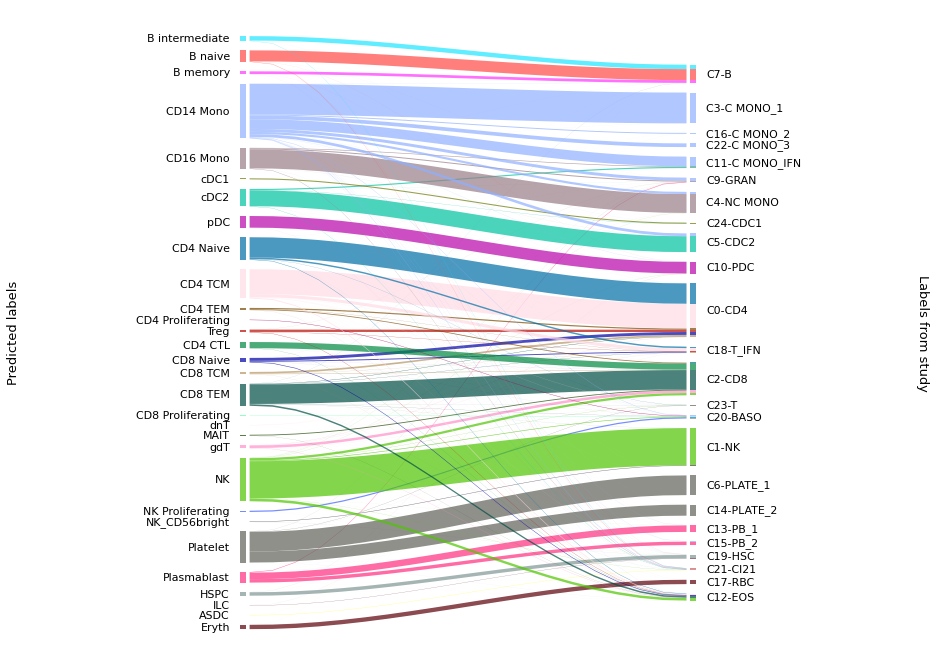

In [48]:
input_data = query.obs[["predicted_l2_scarches", "final_clust_review"]].values.tolist()

ax = alluvial.plot(
    input_data,
    alpha=0.7,
    color_side=0,
    rand_seed=1,
    figsize=(9, 12),
#     disp_width=True,
    wdisp_sep=" " * 2,
    colors=np.array(colors)[color_order],
    fontname="Dejavu Sans",
    labels=("Predicted labels", "Labels from study"),
    label_shift=1,
    a_sort=a_order_main[::-1],
    b_sort=b_order_main[::-1]
)
# ax.set_title('Utility display', fontsize=14, fontname='Dejavu Sans')
fig = plt.gcf()
fig.savefig("figs/alluvial.pdf", dpi=DPI, bbox_inches="tight")
fig.savefig("figs/alluvial.png", dpi=DPI, bbox_inches="tight")
plt.show()


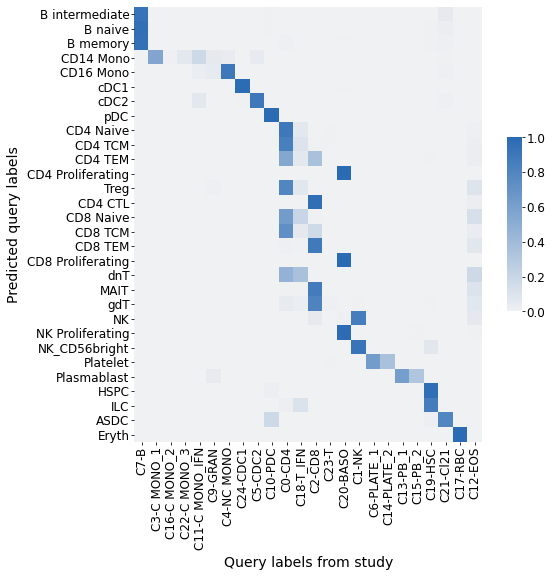

In [49]:
df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_scarches"],
    df["final_clust_review"],
    rownames=["Predicted query labels"],
    colnames=["Query labels from study"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix = confusion_matrix.loc[a_order_main, b_order_main]
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)
fig.savefig("figs/confusion_matrix_scarches_study.pdf", dpi=DPI, bbox_inches="tight")

In [50]:
from sklearn.metrics.cluster import adjusted_mutual_info_score as nmis

nmis(df["predicted_l2_default"], df["predicted_l2_scarches"])

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.8695811782003174

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


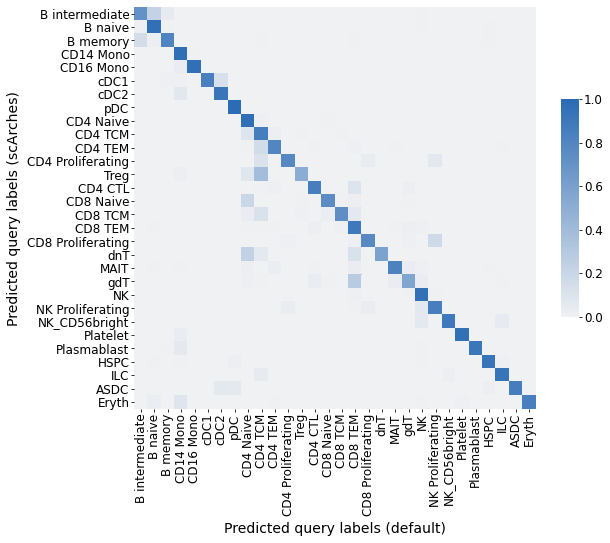

In [51]:
df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_default"],
    df["predicted_l2_scarches"],
    rownames=["Predicted query labels (default)"],
    colnames=["Predicted query labels (scArches)"],
)
confusion_matrix /= confusion_matrix.sum(0)
confusion_matrix = confusion_matrix.loc[a_order_main, a_order_main]

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1,
)
fig.savefig("figs/confusion_matrix.pdf", dpi=DPI, bbox_inches="tight")

In [52]:
query.obs.columns

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth',
       ...
       'CD119_prob_fg', 'CD169_prob_fg', 'CD28_prob_fg', 'CD161_prob_fg',
       'CD163_prob_fg', 'CD138_prob_fg', 'CD164_prob_fg', 'CD144_prob_fg',
       'CD202b_prob_fg', 'CD11c_prob_fg'],
      dtype='object', length=254)

In [53]:
df = query.obs[["predicted_l2_scarches", "Resp", "subj_code", "Age"]]
plot_df = pd.DataFrame()

for state in np.unique(df["Resp"]):
    temp_df = df.loc[df["Resp"] == state]
    for patient in np.unique(temp_df["subj_code"]):
        temp_df2 = temp_df.loc[temp_df["subj_code"] == patient]
        n_cells = len(temp_df2)
        for ct in np.unique(temp_df2["predicted_l2_scarches"]):
            n_ct = np.sum(temp_df2["predicted_l2_scarches"] == ct)
            plot_df.loc[patient, "{} frequency".format(ct)] = n_ct / n_cells
        plot_df.loc[patient, "COVID status"] = state
        plot_df.loc[patient, "Age"] = temp_df2["Age"].values[0]

In [54]:
mait_df = vae_q_arches.differential_expression(query, groupby="predicted_l2_scarches", group1="MAIT", group2="CD8 TEM")
mait_df.iloc[:15]

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


proba_de  proba_not_de  bayes_factor        scale1        scale2  \
SLC4A10       0.9972        0.0028      5.875328  3.716593e-04  8.413372e-06   
RBM24         0.9954        0.0046      5.377086  1.460674e-05  4.388063e-07   
COL5A1        0.9950        0.0050      5.293303  4.587901e-06  2.909743e-07   
PRSS35        0.9948        0.0052      5.253881  5.691573e-05  1.356045e-06   
AC010967.1    0.9942        0.0058      5.144079  4.842841e-06  1.879363e-07   
LINGO4        0.9936        0.0064      5.045035  2.539188e-06  1.340567e-07   
ROR2          0.9930        0.0070      4.954819  2.177335e-05  1.167507e-06   
TANC1         0.9924        0.0076      4.871977  1.062739e-05  1.471166e-06   
SRPX          0.9918        0.0082      4.795386  6.359058e-07  5.935624e-08   
CPLX1         0.9914        0.0086      4.747355  5.308159e-06  6.088906e-07   
CDH2          0.9914        0.0086      4.747355  9.059532e-06  5.585456e-07   
IL1RL1        0.9910        0.0090      4.701489  9.070791e-06  5.253273e-07   
ITPKA         0.9906        0.0094      4.657600  8.289968e-06  7.753231e-07   
KIAA1217      0.9902        0.0098      4.615524  1.968651e-06  1.721134e-07   
KIT           0.9898        0.0102      4.575114  1.052821e-05  7.171403e-07   

            lfc_mean  lfc_median   lfc_std   lfc_min    lfc_max  raw_mean1  \
SLC4A10     6.343220    6.515994  2.273652 -6.055446  12.232746   0.789474   
RBM24       5.807704    5.905029  2.129616 -5.624175  12.233365   0.029240   
COL5A1      4.436336    4.559971  1.675449 -3.415192   9.680816   0.011696   
PRSS35      6.414642    6.658132  2.401522 -7.166931  13.893394   0.116959   
AC010967.1  5.215301    5.350571  2.085665 -4.950922  11.642696   0.011696   
LINGO4      4.746355    4.863859  1.962172 -4.122612  11.010185   0.000000   
ROR2        5.095555    5.240952  2.016950 -3.063067  10.867825   0.011696   
TANC1       3.087253    3.134338  1.216907 -2.599501   7.192841   0.000000   
SRPX        4.187276    4.352971  1.775872 -3.054295   9.223728   0.000000   
CPLX1       3.664425    3.870140  1.473889 -2.945627   7.448051   0.000000   
CDH2        4.332118    4.445941  1.780733 -3.402166   9.351797   0.005848   
IL1RL1      5.131070    5.176425  2.321817 -3.499428  14.108383   0.005848   
ITPKA       3.760872    3.831321  1.642576 -4.420153   9.730227   0.017544   
KIAA1217    3.960688    4.062777  1.655235 -3.702137  10.531967   0.000000   
KIT         4.866192    4.999462  2.020380 -3.869596  10.934251   0.005848   

            raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
SLC4A10      0.006569               0.514620               0.005780   
RBM24        0.000263               0.023392               0.000263   
COL5A1       0.000000               0.011696               0.000000   
PRSS35       0.001576               0.093567               0.001314   
AC010967.1   0.000000               0.011696               0.000000   
LINGO4       0.000000               0.000000               0.000000   
ROR2         0.000788               0.005848               0.000788   
TANC1        0.000525               0.000000               0.000525   
SRPX         0.000000               0.000000               0.000000   
CPLX1        0.000000               0.000000               0.000000   
CDH2         0.000000               0.005848               0.000000   
IL1RL1       0.000000               0.005848               0.000000   
ITPKA        0.000263               0.017544               0.000263   
KIAA1217     0.000000               0.000000               0.000000   
KIT          0.000788               0.005848               0.000525   

            raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
SLC4A10                10.548420              0.072751            True   
RBM24                   0.286853              0.001831            True   
COL5A1                  0.201363              0.000000            True   
PRSS35                  1.594467              0.0

In [55]:
cd4_ctl_df = vae_q_arches.differential_expression(query, groupby="predicted_l2_scarches", group1="CD4 CTL", group2="CD4 Naive")
cd4_ctl_df.iloc[:15]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DE...: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
TXK              1.0           0.0     18.420681  8.092995e-05  0.001127   
CKAP4            1.0           0.0     18.420681  1.105456e-05  0.000071   
CCL4             1.0           0.0     18.420681  2.538632e-03  0.000096   
IFNG             1.0           0.0     18.420681  8.795457e-04  0.000028   
AC069222.1       1.0           0.0     18.420681  9.506674e-08  0.000002   
AC009123.1       1.0           0.0     18.420681  7.129084e-07  0.000014   
ADGRG1           1.0           0.0     18.420681  7.390605e-04  0.000011   
CES1             1.0           0.0     18.420681  3.051336e-04  0.000011   
ADTRP            1.0           0.0     18.420681  1.121249e-05  0.001070   
C12orf75         1.0           0.0     18.420681  1.725024e-03  0.000215   
FHIT             1.0           0.0     18.420681  2.705574e-05  0.001271   
SIAH3            1.0           0.0     18.420681  5.770663e-08  0.000002   
ID3              1.0           0.0     18.420681  9.191229e-06  0.000252   
TESC             1.0           0.0     18.420681  1.815261e-04  0.000032   
TCEAL2           1.0           0.0     18.420681  6.427478e-07  0.000033   

            lfc_mean  lfc_median   lfc_std    lfc_min   lfc_max  raw_mean1  \
TXK        -3.974570   -4.029211  0.911804  -6.717069 -0.460076   0.029038   
CKAP4      -2.719085   -2.761700  0.584572  -4.951064 -0.385954   0.008167   
CCL4        4.707952    4.735092  0.761642   0.509963  7.307347   3.197811   
IFNG        5.131090    5.174179  1.198392   0.568454  9.328301   0.540835   
AC069222.1 -4.743156   -4.790555  1.111981  -8.424583 -0.315132   0.000000   
AC009123.1 -4.441463   -4.492273  0.944986  -7.345173 -0.319597   0.000907   
ADGRG1      6.397890    6.529669  1.034655  -2.468314  8.878596   0.655172   
CES1        4.826903    4.860294  1.031600  -0.326700  8.178075   0.201452   
ADTRP      -6.496162   -6.554306  1.385715 -10.884041 -0.286998   0.010889   
C12orf75    3.047482    3.069562  0.557754   0.578901  4.999983   1.679667   
FHIT       -5.550359   -5.621595  0.865694  -8.055420 -1.280398   0.044465   
SIAH3      -5.362807   -5.392389  1.279405 -10.655048 -0.306835   0.000000   
ID3        -4.812414   -4.842060  0.998754  -9.295849 -0.465912   0.011797   
TESC        2.490564    2.501067  0.511783   0.276880  4.605197   0.186933   
TCEAL2     -5.622927   -5.674028  1.355654 -10.162049 -0.458441   0.000907   

            raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
TXK          0.683298               0.021779               0.459126   
CKAP4        0.030077               0.008167               0.029049   
CCL4         0.033676               0.666969               0.032905   
IFNG         0.010540               0.281307               0.005913   
AC069222.1   0.001799               0.000000               0.001799   
AC009123.1   0.006427               0.000907               0.006170   
ADGRG1       0.006941               0.456443               0.005913   
CES1         0.001799               0.154265               0.001799   
ADTRP        0.493320               0.008167               0.343959   
C12orf75     0.086889               0.778584               0.077635   
FHIT         0.660676               0.034483               0.446787   
SIAH3        0.001285               0.000000               0.001285   
ID3          0.111311               0.010889               0.076864   
TESC         0.006684               0.167877               0.006684   
TCEAL2       0.019537               0.000907               0.015167   

            raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
TXK                     0.201759             13.196454            True   
CKAP4                   0.089354              0.557404            True   
CCL4                   34.366375              0.645325            True   
IFNG                    6.044355              0.165805            True   
AC069222.1              0.000000       

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


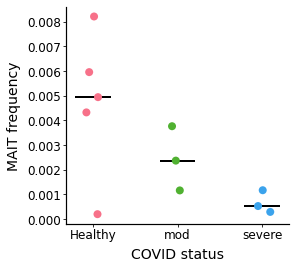

In [56]:
def stripplot_freq(plot_df, y):

    ax = sns.stripplot(x="COVID status", y=y, data=plot_df, s=8, palette=sns.color_palette("husl", 3))

    # distance across the "X" or "Y" stipplot column to span, in this case 40%
    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = plot_df[plot_df['COVID status']==sample_name][y].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=2, color='k')
        
    return ax
        
ax = stripplot_freq(plot_df, "MAIT frequency")
fig = plt.gcf()
fig.savefig("figs/mait_frequency.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


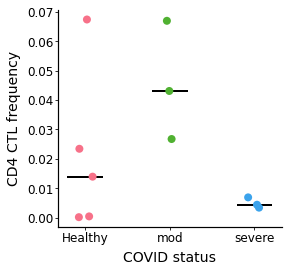

In [57]:
stripplot_freq(plot_df, "CD4 CTL frequency")
fig = plt.gcf()
fig.savefig("figs/cd4_ctl_frequency.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='CD4 Naive frequency'>

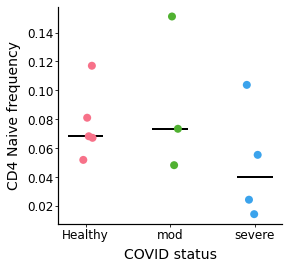

In [58]:
stripplot_freq(plot_df, "CD4 Naive frequency")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='CD8 TEM frequency'>

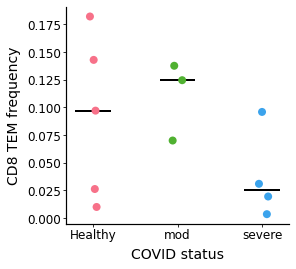

In [59]:
stripplot_freq(plot_df, "CD8 TEM frequency")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='Plasmablast frequency'>

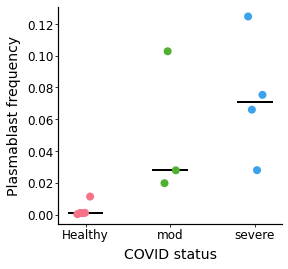

In [60]:
stripplot_freq(plot_df, "Plasmablast frequency")

### Dotplots

In [61]:
query_dot = query.copy()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
sc.pp.normalize_total(query_dot)
sc.pp.log1p(query_dot)

In [63]:
mait_df = mait_df.loc[mait_df["non_zeros_proportion1"] > 0.1]
mait_df = mait_df.loc[mait_df["bayes_factor"] > 3]
mait_df = mait_df.sort_values(by="lfc_mean", ascending=False)

cd4_ctl_df = cd4_ctl_df.loc[cd4_ctl_df["non_zeros_proportion1"] > 0.1]
cd4_ctl_df = cd4_ctl_df.loc[cd4_ctl_df["bayes_factor"] > 3]
cd4_ctl_df = cd4_ctl_df.sort_values(by="lfc_mean", ascending=False)


In [64]:
# drop proteins, have NA column
mait_df = mait_df.dropna()
cd4_ctl_df = cd4_ctl_df.dropna()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
mait_df

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


proba_de  proba_not_de  bayes_factor    scale1    scale2  lfc_mean  \
SLC4A10     0.9972        0.0028      5.875328  0.000372  0.000008  6.343220   
CCR6        0.9894        0.0106      4.536244  0.000177  0.000015  4.261154   
AQP3        0.9862        0.0138      4.269190  0.001065  0.000152  3.248164   
KLRB1       0.9862        0.0138      4.269190  0.007542  0.000835  3.164372   
MYC         0.9816        0.0184      3.976833  0.000487  0.000077  3.111534   
BLK         0.9842        0.0158      4.131819  0.000130  0.000021  2.922025   
LTB         0.9716        0.0284      3.532555  0.007283  0.001511  2.740779   
CCR2        0.9786        0.0214      3.822732  0.000106  0.000017  2.653239   
IL7R        0.9668        0.0332      3.371441  0.011022  0.002661  2.605134   
RCAN3       0.9622        0.0378      3.236913  0.000581  0.000169  2.530694   
IL18RAP     0.9816        0.0184      3.976833  0.000236  0.000051  2.358275   
CEBPD       0.9786        0.0214      3.822732  0.000861  0.000188  2.169148   
NCR3        0.9646        0.0354      3.305001  0.001497  0.000359  2.008357   
HPGD        0.9546        0.0454      3.045780  0.000229  0.000063  1.910420   
JAML        0.9708        0.0292      3.503951  0.000607  0.000208  1.643949   
IL18R1      0.9648        0.0352      3.310874  0.000350  0.000115  1.625847   
CTSA        0.9726        0.0274      3.569430  0.000615  0.000224  1.489062   
CYTOR       0.9572        0.0428      3.107474  0.000295  0.000730 -1.301272   
HLA-DPA1    0.9592        0.0408      3.157417  0.000517  0.001889 -1.788711   
HLA-DPB1    0.9726        0.0274      3.569430  0.000658  0.002637 -1.952986   
ZEB2        0.9618        0.0382      3.225971  0.000353  0.001394 -2.110379   
CD8B        0.9616        0.0384      3.220541  0.000490  0.002327 -2.282042   

          lfc_median   lfc_std   lfc_min    lfc_max  raw_mean1  raw_mean2  \
SLC4A10     6.515994  2.273652 -6.055446  12.232746   0.789474   0.006569   
CCR6        4.462122  1.754021 -5.745355   8.716979   0.175439   0.008408   
AQP3        3.448099  1.401987 -2.628312   6.600992   0.865497   0.120337   
KLRB1       3.324266  1.502145 -5.117533   7.672014   9.286544   0.937199   
MYC         3.321734  1.372426 -3.070898   6.284841   0.415205   0.069627   
BLK         3.049127  1.302526 -3.357224   6.525147   0.122807   0.011823   
LTB         3.030949  1.359006 -2.897487   5.453651   8.649116   1.399360   
CCR2        2.721555  1.286334 -4.397406   6.183800   0.111111   0.007882   
IL7R        2.676075  1.532097 -3.545352   7.020951   9.350872   2.373863   
RCAN3       2.868069  1.500822 -3.358098   5.747713   0.315790   0.150815   
IL18RAP     2.439220  1.177325 -3.551010   6.508770   0.228070   0.033894   
CEBPD       2.276607  0.915295 -2.692988   5.148572   1.093567   0.086443   
NCR3        2.127748  1.134987 -2.325719   5.447648   1.859649   0.399104   
HPGD        1.904966  1.165095 -2.325253   6.136999   0.251462   0.042827   
JAML        1.676566  0.751853 -1.585194   3.878403   0.502924   0.075145   
IL18R1      1.656741  0.885174 -2.313933   5.161678   0.339181   0.100631   
CTSA        1.566898  0.633582 -1.154608   3.203542   0.543860   0.241723   
CYTOR      -1.362920  0.700992 -4.161351   2.635216   0.134503   0.703619   
HLA-DPA1   -1.824848  0.968289 -5.487220   2.173393   0.362573   2.157879   
HLA-DPB1   -2.012236  0.918516 -5.292667   1.987440   0.368421   2.831802   
ZEB2       -2.361503  1.254943 -5.259849   4.418355   0.134503   1.440076   
CD8B       -2.369498  1.707897 -8.431999   5.287687   0.397661   2.379369   

          non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1  \
SLC4A10                0.514620               0.005780             10.548420   
CCR6                   0.152047               0.006043              2.287815   
AQP3                   0.514620               0.088019             11.436436   
KLRB1                  0.918129               0.291119            123.360855 

https://www.nature.com/articles/s41422-020-00455-9

https://immunology.sciencemag.org/content/5/51/eabe1670

https://www.biorxiv.org/content/10.1101/2020.06.12.148916v1.full.pdf

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a f

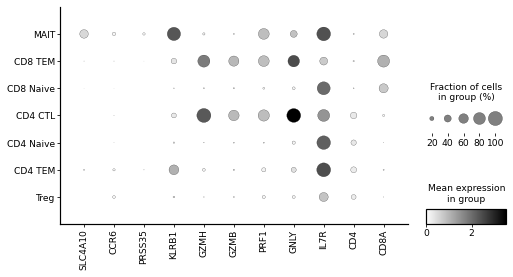

In [66]:
include = ["MAIT", "CD8 TEM", "CD8 Naive", "CD4 CTL", "CD4 Naive", "CD4 TEM", "Treg"]
include_mask = [c in include for c in query_dot.obs.predicted_l2_scarches]

fig = sc.pl.dotplot(
    query_dot[include_mask],
    groupby="predicted_l2_scarches",
    var_names=["SLC4A10", "CCR6", "PRSS35", "KLRB1"] + ["GZMH", "GZMB", "PRF1", "GNLY"] + ["IL7R", "CD4", "CD8A"],
    categories_order=include,
    cmap="binary",
    figsize=(8, 4),
    return_fig=True
#     dendrogram=True,
#     swap_axes=True,
)
fig.savefig("figs/dotplot.pdf", bbox_inches="tight")
plt.show()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a f

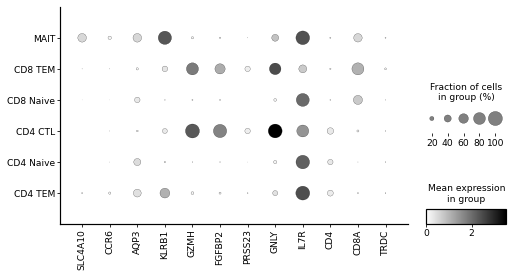

In [67]:
include = ["MAIT", "CD8 TEM", "CD8 Naive", "CD4 CTL", "CD4 Naive", "CD4 TEM"]
include_mask = [c in include for c in query_dot.obs.predicted_l2_scarches]

sc.pl.dotplot(
    query_dot[include_mask],
    groupby="predicted_l2_scarches",
    var_names=mait_df.index[:4].to_list() + cd4_ctl_df.index[:4].to_list() + ["IL7R", "CD4", "CD8A", "TRDC"],
    categories_order=include,
    cmap="binary",
    figsize=(8, 4),
#     dendrogram=True,
#     swap_axes=True,
)


## Run Seurat

In [68]:
%load_ext rpy2.ipython

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
from rpy2.robjects.vectors import ListVector, StrVector
cells_for_seurat = StrVector(ref.obs_names.to_list())

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
%%R
library(Seurat)
library(SeuratDisk)

R[write to console]: Attaching SeuratObject

R[write to console]: Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [71]:
%%R
# !wget https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat -O data/pbmc_multimodal.h5seurat
reference <- LoadH5Seurat("data/pbmc_multimodal.h5seurat")

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing ADT with data

R[write to console]: Adding counts for ADT

R[write to console]: Adding variable feature information for ADT

R[write to console]: Adding miscellaneous information for ADT

R[write to console]: Initializing SCT with data

R[write to console]: Adding counts for SCT

R[write to console]: Adding variable feature information for SCT

R[write to console]: Adding miscellaneous information for SCT

R[write to console]: Adding reduction apca

R[write to console]: Adding cell embeddings for apca

R[write to console]: Adding feature loadings for apca

R[write to console]: Adding miscellaneous information for apca

R[write to console]: Adding reduction aumap

R[write to console]: Adding cell embeddings for aumap

R[write to console]: Adding miscellaneous information for aumap

R[write to console]: Adding reduction pca

R[write to console]: Adding cell embeddings for pca

R[write to console]: Adding fea

In [72]:
%%R -i cells_for_seurat
reference <- subset(reference, cells=cells_for_seurat)

In [73]:
%%R
reference

An object of class Seurat 
20957 features across 152094 samples within 2 assays 
Active assay: SCT (20729 features, 5000 variable features)
 1 other assay present: ADT
 6 dimensional reductions calculated: apca, aumap, pca, spca, umap, wnn.umap


In [74]:
%%R
Convert("data/scarches_totalvi_query.h5ad", dest = "h5seurat", overwrite = TRUE)
query <- LoadH5Seurat("data/scarches_totalvi_query.h5seurat")

R[write to console]: Warning:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warning:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Adding counts for RNA

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous information

R[write to console]: Adding tool-specific results



In [75]:
%%R
query <- SCTransform(query, verbose = FALSE)
anchors <- FindTransferAnchors(
  reference = reference,
  query = query,
  normalization.method = "SCT",
  reference.reduction = "spca",
  dims = 1:50
)

R[write to console]: Normalizing query using reference SCT model

R[write to console]: Projecting cell embeddings

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 35049 anchors



In [76]:
%%R
query <- MapQuery(
  anchorset = anchors,
  query = query,
  reference = reference,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"
  ),
  reference.reduction = "spca", 
  reduction.model = "wnn.umap"
)

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

  |                                                  | 0 % ~calculating  

R[write to console]: Integrating dataset 2 with reference dataset

R[write to console]: Finding integration vectors

R[write to console]: Integrating data

R[write to console]: Warning:
R[write to console]:  Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.spca_ to refspca_



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Warning:
R[write to console]:  Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.spca_ to refspca_

R[write to console]: Warning:
R[write to console]:  All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to refspca_

R[write to console]: Computing nearest neighbors

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: Running UMAP projection

R[write to console]: 20:56:45 Read 54796 rows and found  numeric columns

R[write to console]: 20:56:45 Processing block 1 of 1

R[write to console]: 20:56:45 Commencing smooth kNN distance calibration using 1 thread

R[write to console]: 20:56:45 Ini

In [77]:
# %%R
# p1 = DimPlot(query, reduction = "ref.umap", group.by = "predicted.celltype.l1", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
# p2 = DimPlot(query, reduction = "ref.umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 3 ,repel = TRUE) + NoLegend()
# p1 + p2

In [78]:
%%R

pred = query[["predicted.celltype.l2"]]

In [79]:
%%R -o emb

emb = Embeddings(query, reduction = "ref.spca")

In [80]:
# from rpy2.robjects import r
# import pandas as pd
# r["pred"]

import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    query_pred_seurat = ro.conversion.rpy2py(ro.r["pred"])
    
query_pred_seurat

predicted.celltype.l2
AAACCCACACCAGCGT-1           Plasmablast
AAACCCACATCTCAAG-1                    NK
AAACGAAAGACCTGGA-1           Plasmablast
AAACGCTCAGTGGGTA-1               CD8 TEM
AAACGCTGTAGCTTGT-1              B memory
...                                  ...
TTTGGTTTCCAATCTT-1             CD14 Mono
TTTGTTGAGACGTCCC-1             CD14 Mono
TTTGTTGAGGTATTGA-1             CD14 Mono
TTTGTTGCAGGCGATA-1                  MAIT
TTTGTTGTCTTCTGTA-1                    NK

[54796 rows x 1 columns]

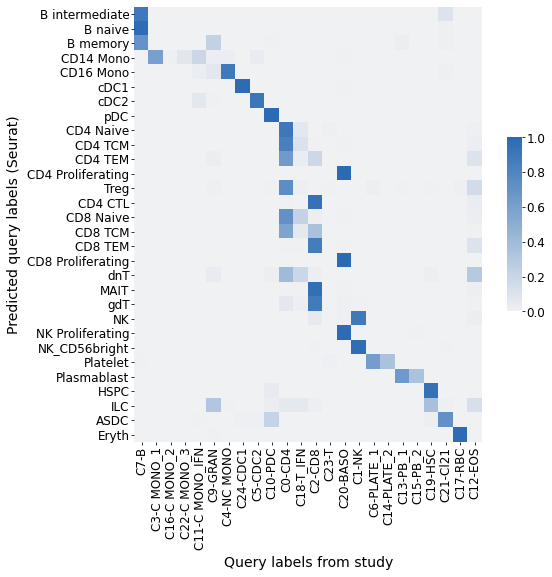

In [113]:
query.obs["predicted_l2_seurat"] = query_pred_seurat["predicted.celltype.l2"]

df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_seurat"],
    df["final_clust_review"],
    rownames=["Predicted query labels (Seurat)"],
    colnames=["Query labels from study"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix = confusion_matrix.loc[a_order_main, b_order_main]
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)
fig.savefig("figs/confusion_matrix_seurat_study.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


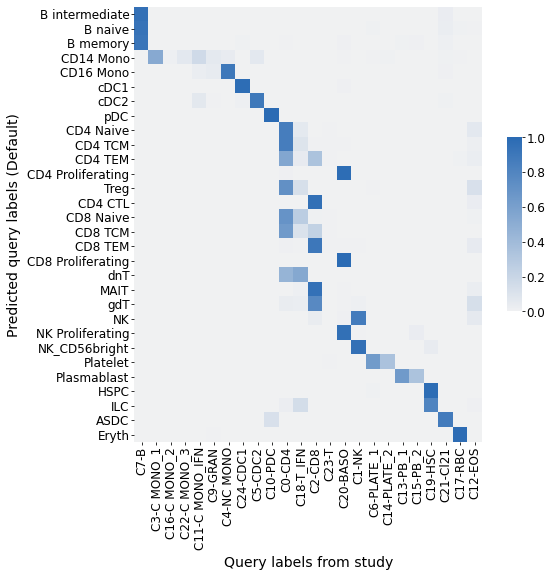

In [115]:
df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_default"],
    df["final_clust_review"],
    rownames=["Predicted query labels (Default)"],
    colnames=["Query labels from study"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix = confusion_matrix.loc[a_order_main, b_order_main]
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)
fig.savefig("figs/confusion_matrix_default_study.pdf", dpi=DPI, bbox_inches="tight")

## Compare predictions

In [97]:
df = query.obs[["predicted_l2_scarches", "final_clust_review", "predicted_l2_default"]].copy()

df["predicted_l2_seurat"] = query_pred_seurat["predicted.celltype.l2"]


df["predicted_l2_scarches_int"] = [ref_to_int[i] for i in df["predicted_l2_scarches"].values]
df["predicted_l2_default_int"] = [ref_to_int[i] for i in df["predicted_l2_default"].values]
df["predicted_l2_seurat_int"] = [ref_to_int[i] for i in df["predicted_l2_seurat"].values]
df["query_int"] = [query_to_int[i] for i in df["final_clust_review"].values]

In [98]:
clean_df = df.dropna()
print(len(clean_df))
clean_df.head()

48416


predicted_l2_scarches final_clust_review  \
AAACCCACACCAGCGT-1           Plasmablast           C15-PB_2   
AAACGAAAGACCTGGA-1           Plasmablast           C13-PB_1   
AAACGCTGTAGCTTGT-1              B memory               C7-B   
AAACGCTGTTTGACAC-1           Plasmablast           C15-PB_2   
AAACGCTTCGGAGTAG-1                 Eryth            C17-RBC   

                   predicted_l2_default predicted_l2_seurat  \
AAACCCACACCAGCGT-1          Plasmablast         Plasmablast   
AAACGAAAGACCTGGA-1          Plasmablast         Plasmablast   
AAACGCTGTAGCTTGT-1             B memory            B memory   
AAACGCTGTTTGACAC-1          Plasmablast         Plasmablast   
AAACGCTTCGGAGTAG-1                Eryth               Eryth   

                    predicted_l2_scarches_int  predicted_l2_default_int  \
AAACCCACACCAGCGT-1                        9.0                       9.0   
AAACGAAAGACCTGGA-1                        9.0                       9.0   
AAACGCTGTAGCTTGT-1                        0.0                       0.0   
AAACGCTGTTTGACAC-1                        9.0                       9.0   
AAACGCTTCGGAGTAG-1                       11.0                      11.0   

                    predicted_l2_seurat_int  query_int  
AAACCCACACCAGCGT-1                      9.0        9.0  
AAACGAAAGACCTGGA-1                      9.0        9.0  
AAACGCTGTAGCTTGT-1                      0.0        0.0  
AAACGCTGTTTGACAC-1                      9.0        9.0  
AAACGCTTCGGAGTAG-1                     11.0       11.0

In [99]:
np.mean(clean_df["predicted_l2_seurat"] == clean_df["predicted_l2_scarches"])

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9141812623925974

In [100]:
clean_df.query("final_clust_review == 'C12-EOS'")

Empty DataFrame
Columns: [predicted_l2_scarches, final_clust_review, predicted_l2_default, predicted_l2_seurat, predicted_l2_scarches_int, predicted_l2_default_int, predicted_l2_seurat_int, query_int]
Index: []

In [102]:
from sklearn.metrics import f1_score, classification_report, adjusted_mutual_info_score

y_true = clean_df["query_int"]
print(classification_report(y_true, clean_df["predicted_l2_scarches_int"]))
print(classification_report(y_true, clean_df["predicted_l2_seurat_int"]))


print(f1_score(y_true, clean_df["predicted_l2_scarches_int"], average="weighted"))
print(f1_score(y_true, clean_df["predicted_l2_default_int"], average="weighted"))
print(f1_score(y_true, clean_df["predicted_l2_seurat_int"], average="weighted"))

print(adjusted_mutual_info_score(y_true, clean_df["predicted_l2_scarches_int"]))
print(adjusted_mutual_info_score(y_true, clean_df["predicted_l2_default_int"]))
print(adjusted_mutual_info_score(y_true, clean_df["predicted_l2_seurat_int"]))

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3175
         1.0       0.89      0.96      0.92      8119
         2.0       1.00      0.82      0.90       228
         3.0       0.92      0.85      0.88      3225
         4.0       1.00      0.97      0.99      2058
         5.0       0.98      0.91      0.94      9233
         6.0       0.79      0.87      0.83      3688
         7.0       0.94      1.00      0.97      6526
         8.0       1.00      1.00      1.00      5322
         9.0       0.99      0.96      0.98      1793
        10.0       0.98      0.93      0.95       629
        11.0       1.00      0.99      0.99       759
        12.0       0.96      0.89      0.93      3661

    accuracy                           0.94     48416
   macro avg       0.96      0.93      0.94     48416
weighted avg       0.94      0.94      0.94     48416

              precision    recall  f1-score   support

         0.0       0.99 

In [103]:
print(adjusted_mutual_info_score(query.obs["predicted_l2_default"], query.obs["predicted_l2_scarches"]))

0.8695811782003174


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
print(adjusted_mutual_info_score(query.obs["predicted_l2_seurat"], query.obs["predicted_l2_scarches"]))

0.8376241185549222


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


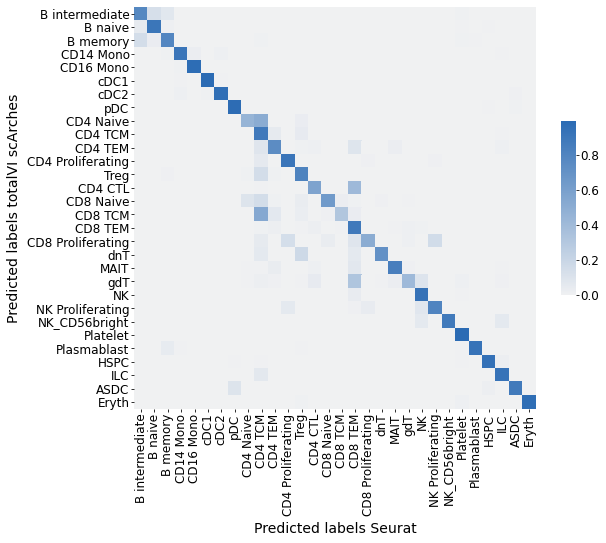

In [118]:
df = query.obs

confusion_matrix = pd.crosstab(
    df["predicted_l2_scarches"],
    df["predicted_l2_seurat"],
    colnames=["Predicted labels Seurat"],
    rownames=["Predicted labels totalVI scArches"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)

a_order = np.unique(df["predicted_l2_scarches"])
confusion_matrix = confusion_matrix.loc[a_order_main, a_order_main]

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)
fig.savefig("figs/confusion_matrix_scarches_seurat.pdf", dpi=DPI, bbox_inches="tight")

In [125]:


int_to_query = {}
for k, v in query_to_int.items():
    int_to_query[v] = int_to_query.get(v, []) + [k]
    
int_to_ref = {}
for k, v in ref_to_int.items():
    int_to_ref[v] = int_to_ref.get(v, []) + [k]

int_to_ref

{0: ['B intermediate', 'B naive', 'B memory'],
 1: ['CD14 Mono'],
 12: ['CD16 Mono'],
 2: ['cDC1'],
 3: ['cDC2'],
 4: ['pDC'],
 5: ['CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD4 Proliferating', 'Treg'],
 nan: ['CD4 CTL', 'dnT', 'MAIT', 'gdT', 'ILC', 'ASDC'],
 6: ['CD8 Naive', 'CD8 TCM', 'CD8 TEM', 'CD8 Proliferating'],
 7: ['NK', 'NK Proliferating', 'NK_CD56bright'],
 8: ['Platelet'],
 9: ['Plasmablast'],
 10: ['HSPC'],
 11: ['Eryth']}

In [126]:
int_to_query

{0: ['C7-B'],
 1: ['C3-C MONO_1', 'C16-C MONO_2', 'C22-C MONO_3', 'C11-C MONO_IFN'],
 nan: ['C9-GRAN', 'C18-T_IFN', 'C23-T', 'C20-BASO', 'C21-Cl21', 'C12-EOS'],
 12: ['C4-NC MONO'],
 2: ['C24-CDC1'],
 3: ['C5-CDC2'],
 4: ['C10-PDC'],
 5: ['C0-CD4'],
 6: ['C2-CD8'],
 7: ['C1-NK'],
 8: ['C6-PLATE_1', 'C14-PLATE_2'],
 9: ['C13-PB_1', 'C15-PB_2'],
 10: ['C19-HSC'],
 11: ['C17-RBC']}